In [1]:
import os
from os import path
import re
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess
from utilities.seq import aa_to_int_from_path
from utilities.tree import run_fitch, run_iqtree, get_depths
from utilities.utils import get_directory, parse_model_name, get_real_internals 
from utilities.vae import load_model
from scripts.decode_recon_embeds import (
    get_profile_leaves,
    get_iqtree_ancseqs, 
    get_ardca_ancseqs,
    get_recon_ancseqs, 
    get_finch_ancseqs,
    get_prior_seqs
)
# mpl.rcParams.update({
#     "text.usetex": True,               # Use LaTeX to render text
#     "font.family": "serif",
#     "font.serif": ["Computer Modern"], # Same font as LaTeX default
#     "axes.labelsize": 13,
#     "font.size": 13,
#     "legend.fontsize": 11,
#     "xtick.labelsize": 11,
#     "ytick.labelsize": 11,
# })

Modify the following as needed:

In [3]:

tree_path = "trees/fast_trees/1250/COG28.clean.tree"
nc = 21 # Number of amino acids in the vocabulary (21 because there are gaps in these simulated MSAs)
MSA_ids = ["COG28-s1.0-pottsPF00565", "COG28-PF00565"]
data_paths = [
    path.join("msas/potts/processed/1250", MSA_ids[0]), 
    path.join("msas/ardca/processed/1250", MSA_ids[1])
    ]
MSA_paths = [
    path.join("msas/potts/raw/1250", f"{MSA_ids[0]}.fa"),
    path.join("msas/ardca/raw/1250", f"{MSA_ids[1]}.fa"),
    ]
aa_idxs = [aa_to_int_from_path(data_path) for data_path in data_paths]
# First MSA has length 97, second MSA has length 95
nls = [97, 95]
# When models were trained
date_suffix = "_2025-07-22.pt"
# Models
model_names = ["ding_layers500_ld2_wd0.005_epoch500",
               "ding_layers500_ld20_wd0.01_epoch50",
               "ding_layers500_ld20_wd0.01_epoch500"]

In [5]:
recon_vae_dict = {}
for MSA_id, data_path, nl in zip(MSA_ids, data_paths, nls):
    model_dir = get_directory(data_path, "saved_models")
    embeds_dir = get_directory(data_path, "embeddings", data_subfolder=True)
    recon_vae_dict[MSA_id] = {}
    for name in model_names:
        # models for potts and ardca saved on different dates
        name = name + date_suffix
        # Load model
        is_trans, ld, num_hidden_units, dim_aa_embed, one_hot = parse_model_name(name)
        ding_model = name.startswith("ding")
        model_path = os.path.join(model_dir, name)
        model = load_model(model_path, nl=nl, nc=nc, ding_model=ding_model,
                            num_hidden_units=num_hidden_units, nlatent=ld,
                            one_hot=one_hot, dim_aa_embed=dim_aa_embed, trans=is_trans)
        # Estimated ancestral embeddings
        est_embeds_path = path.join(embeds_dir,
                               name.replace(".pt", "_anc-embeddings.csv"))
        est_anc_embeds = pd.read_csv(est_embeds_path, index_col = "id")
        est_anc_embeds = est_anc_embeds.loc[:, est_anc_embeds.columns.str.startswith("dim")]

        #Reconstruct b
        true_embeds_path = path.join(embeds_dir,
                               name.replace(".pt", "_embeddings.csv"))
        true_embeds = pd.read_csv(true_embeds_path, index_col = "id")
        true_anc_embeds = true_embeds.loc[est_anc_embeds.index, true_embeds.columns.str.startswith("dim")]

        # Save model data
        recon_vae_dict[MSA_id][name] = {
            "path": model_path,
            "model": model,
            "est_embeds": est_anc_embeds,
            "recon_seqs" : get_recon_ancseqs(model, est_anc_embeds),
            "prior_seqs" : get_prior_seqs(model, n_anc=len(est_anc_embeds)),
            "decoded_true" : get_recon_ancseqs(model, true_anc_embeds)
            }

# Get list of ancestor ids
anc_id = recon_vae_dict[MSA_ids[0]][model_names[0] + date_suffix]["est_embeds"].index.tolist() 

Get modal sequence

In [6]:
mod_seq_dict = {}
for MSA_id, data_path in zip(MSA_ids, data_paths):
    mod_seq_dict[MSA_id] = get_profile_leaves(data_path, n_anc=len(est_anc_embeds))

Get Fitch Reconstructions

In [7]:
recon_fitch_dict = {}
for aa_idx, MSA_id, data_path in zip(aa_idxs, MSA_ids, data_paths):
    processed_msa_path = os.path.join(data_path, "seq_msa_char.fasta")
    _, seq_dict = run_fitch(processed_msa_path, tree_path)
    recon_fitch_dict[MSA_id] = get_finch_ancseqs(seq_dict, aa_idx, anc_id)

Get IQTree Reconsructions

In [8]:
recon_iq_dict = {} 
for aa_index, MSA_id, data_path in zip(aa_idxs, MSA_ids, data_paths):
    iqtree_dir = get_directory(data_path, "reconstructions/iqtree")
    os.makedirs(iqtree_dir, exist_ok=True)
    processed_msa_path = os.path.join(data_path, "seq_msa_char.fasta")
    run_iqtree(processed_msa_path, tree_path, iqtree_dir, redo=True)
    recon_iq_dict[MSA_id] = get_iqtree_ancseqs(iqtree_dir, aa_index,  anc_id)

Reconstructions for Node A1251 not found in IQTree output 
    because it is the root node in the cleaned tree, and for some reason, 
    IQTree does not reconstruct the sequence at the root node.
Reconstructions for Node A1251 not found in IQTree output 
    because it is the root node in the cleaned tree, and for some reason, 
    IQTree does not reconstruct the sequence at the root node.


Get ArDCA Reconstructions

In [9]:
recon_ardca_dict = {}
for aa_index, MSA_id, data_path in zip(aa_idxs, MSA_ids, data_paths):
    ardca_dir = get_directory(data_path, "reconstructions/ardca")
    os.makedirs(iqtree_dir, exist_ok=True)
    recon_ardca_dict[MSA_id] = get_ardca_ancseqs(ardca_dir, aa_index, anc_id)

Get real sequences

In [10]:
real_dict = {}
for aa_index, MSA_id, MSA_path, data_path in zip(aa_idxs, MSA_ids, MSA_paths, data_paths):
    with open(f"{data_path}/pos_preserved.pkl", "rb") as f:
        pos_preserved = pickle.load(f)
    real_dict[MSA_id], _ = get_real_internals(MSA_path, aa_index, anc_id, pos_preserved=pos_preserved)

Place reconstructed sequences under all methods in a single dictionary for acceptance by `plot_all_errror()`

In [11]:
all_est_seqs = {}
for MSA_id, data_path in zip(MSA_ids, data_paths):
    all_est_seqs[MSA_id] = {}
    all_est_seqs[MSA_id]["parsimony"] = recon_fitch_dict[MSA_id]
    all_est_seqs[MSA_id]["iqtree"] = recon_iq_dict[MSA_id]
    all_est_seqs[MSA_id]["ardca"] = recon_ardca_dict[MSA_id]
    all_est_seqs[MSA_id]["modal"] = mod_seq_dict[MSA_id]
    for name in model_names:
        all_est_seqs[MSA_id][name] = recon_vae_dict[MSA_id][name + date_suffix]["recon_seqs"] 
        all_est_seqs[MSA_id][f"{name}_decoded_true"] = recon_vae_dict[MSA_id][name + date_suffix]["decoded_true"]

Sanity check

In [12]:
all_est_seqs[MSA_ids[0]].keys()

dict_keys(['parsimony', 'iqtree', 'ardca', 'modal', 'ding_layers500_ld2_wd0.005_epoch500', 'ding_layers500_ld2_wd0.005_epoch500_decoded_true', 'ding_layers500_ld20_wd0.01_epoch50', 'ding_layers500_ld20_wd0.01_epoch50_decoded_true', 'ding_layers500_ld20_wd0.01_epoch500', 'ding_layers500_ld20_wd0.01_epoch500_decoded_true'])

Get depths

In [ ]:
# Depths of the ancestral nodes
depths = get_depths(tree_path)
ordered_depths = [depths[id] for id in anc_id]

Plot aesthetics

In [29]:
lowess_smooth_frac = 0.3

# Aesthetics for baseline
baselines = [method for method in all_est_seqs["COG28-s1.0-pottsPF00565"].keys() if "ding" not in method] 
baseline_palette = sns.color_palette("colorblind", len(baselines))
legend_baselines = [] # handle for legend

# Aesthetics for models
#Keys are tuples (latent_dimension, num_epochs)
model_lstyles = {
    (2, 500): '--',
    (20, 50): '-.',
    (20, 500): ':'
}
model_labels = {(ld, n_epoch): f"VAE (latent dim = {ld})" for ld, n_epoch in model_lstyles.keys()}

# Figure dimensions
width_in_inches = 4*len(MSA_ids)
height_in_inches = 3

For each data set (Potts and Autoregressive), produce a plot that contains the Hamming error versus depth curves for each model/approach. Place these next to each other.

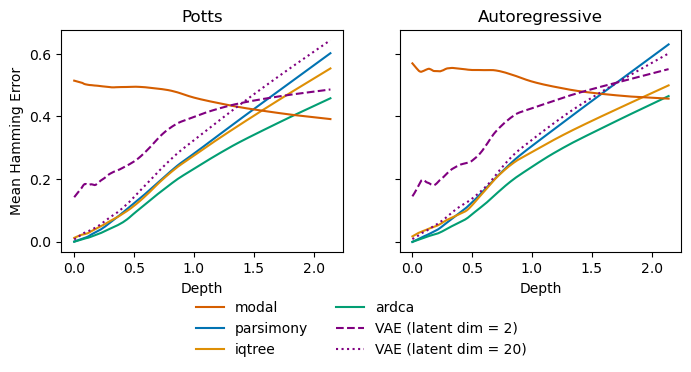

In [30]:
# Set up the figure
fig, axs = plt.subplots(1, len(MSA_ids), figsize=(width_in_inches, height_in_inches), sharey=True)
if len(MSA_ids) == 1:
    axs = [axs]
#fig.suptitle("Ancestral Reconstruction Hamming Error vs Depth in Tree", fontsize=16)
# fig.text(0.5, 0.9, 
#          "for various MSAs simulated with LG model on COG28 Tree", 
#          ha='center', fontsize=10)
axs[0].set_ylabel("Mean Hamming Error")

# Plot the errors for each MSA
titles = ["Potts", "Autoregressive"]
legend_models = [] # handle for legend
for ax, MSA_id, title in zip(axs, MSA_ids, titles):
    #set a title for each MSA_id subplot if desired
    ax.set_title(title)
    ax.set_xlabel("Depth")
    est_seqs = all_est_seqs[MSA_id]
    real_seqs = real_dict[MSA_id]
    #Baseline approaches
    for baseline, color in zip(baselines, baseline_palette):
        # Compute the hamming error of the method
        ham_errors = []
        for (est_seq, real_seq) in zip(est_seqs[baseline], real_seqs):
            if all(est_seq == -1):  # handle missing reconstructions (iqtree)
                ham_errors.append(None)
                continue
            ham_errors.append(np.mean(est_seq != real_seq))
        # Add LOESS smooth
        valid_data = [(d, e) for d, e in zip(ordered_depths, ham_errors) if e is not None]
        if valid_data:
            valid_depths, valid_errors = zip(*valid_data)
            try:
                smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
                h, = ax.plot(smooth[:,0], smooth[:,1], color=color, label=baseline)
                if MSA_id == MSA_ids[0]: # only append to the legend once
                    legend_baselines.append(h)
            except Exception as e:
                print(f"Error while smoothing and plotting for {baseline}: {e}")
    # Our approaches
    for model in model_names:
        
        #Get model aesthetics
        model_ld = int(re.search(r"ld(\d+)", model).group(1))
        model_nepoch = int(re.search(r"epoch(\d+)", model).group(1))
        model_lstyle = model_lstyles[(model_ld, model_nepoch)]
        model_label = model_labels[(model_ld, model_nepoch)]
        # don't plot 50 epoch models
        if model_nepoch == 50:
            continue

        ham_errors = []
        for (est_seq, real_seq) in zip(est_seqs[model], real_seqs):
            if all(est_seq == -1):  # handle missing reconstructions (iqtree)
                ham_errors.append(None)
                continue
            ham_errors.append(np.mean(est_seq != real_seq))
        # Add LOESS smooth
        valid_data = [(d, e) for d, e in zip(ordered_depths, ham_errors) if e is not None]
        if valid_data:
            valid_depths, valid_errors = zip(*valid_data)
            try:
                smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
                h, = ax.plot(smooth[:,0], smooth[:,1], color="purple", linestyle=model_lstyle, label=model_label)
                if MSA_id == MSA_ids[0]: # only append to the legend once
                    legend_models.append(h)
            except Exception as e:
                print(f"Error while smoothing and plotting for {baseline}: {e}")

# Combine baseline and model legends
combined_legend_handles = (
    [legend_baselines[baselines.index("modal")]] + 
    [h for i, h in enumerate(legend_baselines) if baselines[i] != "modal"] +
    legend_models 
)
combined_legend_labels = [h.get_label() for h in combined_legend_handles]

# Add a single legend to the figure
fig.legend(
    combined_legend_handles,
    combined_legend_labels,
    frameon=False,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.01),
    ncol=2
)
#fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("figures/epistatic_COG28_error-vs-depth.pdf", dpi=300, bbox_inches='tight')

    

For each dataset, plot the error versus depth curve for two different reconstructions:

1. Reconstructions resulting from decoding true embeddings of ancestral sequences.
2. Reconstructions resulting from decoding estimated embeddings of ancestral sequences (with Brownian motion model)

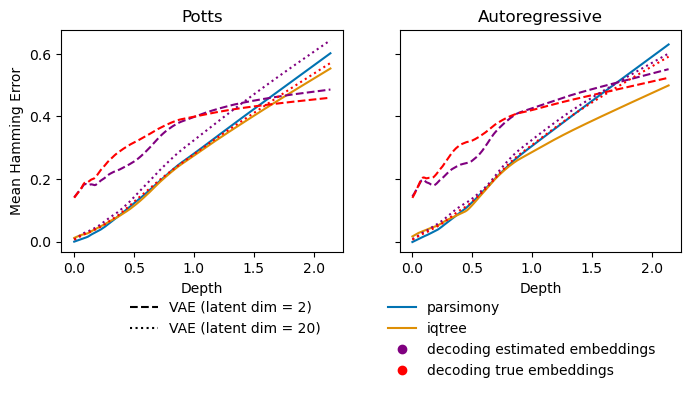

In [ ]:
# Set up the figure
fig, axs = plt.subplots(1, len(MSA_ids), figsize=(width_in_inches, height_in_inches), sharey=True)
if len(MSA_ids) == 1:
    axs = [axs]
#fig.suptitle("Ancestral Reconstruction Hamming Error vs Depth in Tree", fontsize=16)
# fig.text(0.5, 0.9, 
#          "for various MSAs simulated with LG model on COG28 Tree", 
#          ha='center', fontsize=10)
axs[0].set_ylabel("Mean Hamming Error")
line_type_handles = [] 
line_color_handles = []
# Plot the errors for each MSA
for ax, MSA_id, title in zip(axs, MSA_ids, titles):
    #set a title for each MSA_id subplot if desired
    ax.set_title(title)
    ax.set_xlabel("Depth")
    est_seqs = all_est_seqs[MSA_id]
    real_seqs = real_dict[MSA_id]


    # Plot the Hamming error for the baseline parsimony method
    ham_errors = []
    for (est_seq, real_seq) in zip(est_seqs['parsimony'], real_seqs):
        if all(est_seq == -1):  # handle missing reconstructions (iqtree)
            ham_errors.append(None)
            continue
        ham_errors.append(np.mean(est_seq != real_seq))
    # Add LOESS smooth
    valid_data = [(d, e) for d, e in zip(ordered_depths, ham_errors) if e is not None]
    if valid_data:
        valid_depths, valid_errors = zip(*valid_data)
        try:
            smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
            h, = ax.plot(smooth[:,0], smooth[:,1], color=baseline_palette[0], label='parsimony')
            if MSA_id == MSA_ids[0]: # only append to the legend once
                line_color_handles.append(plt.Line2D([], [], color=baseline_palette[0], label="parsimony"))
        except Exception as e:
            print(f"Error while smoothing and plotting for iqtree: {e}")

    # Plot the Hamming error for the baseline iqtree method
    ham_errors = []
    for (est_seq, real_seq) in zip(est_seqs['iqtree'], real_seqs):
        if all(est_seq == -1):  # handle missing reconstructions (iqtree)
            ham_errors.append(None)
            continue
        ham_errors.append(np.mean(est_seq != real_seq))
    # Add LOESS smooth
    valid_data = [(d, e) for d, e in zip(ordered_depths, ham_errors) if e is not None]
    if valid_data:
        valid_depths, valid_errors = zip(*valid_data)
        try:
            smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
            h, = ax.plot(smooth[:,0], smooth[:,1], color=baseline_palette[1], label='iqtree')
            if MSA_id == MSA_ids[0]: # only append to the legend once
                line_color_handles.append(plt.Line2D([], [], color=baseline_palette[1], label="iqtree"))
        except Exception as e:
            print(f"Error while smoothing and plotting for iqtree: {e}")
            
    # Go through each VAE
    for model in model_names:

        #Get model aesthetics
        model_nepoch = int(re.search(r"epoch(\d+)", model).group(1))
        model_ld = int(re.search(r"ld(\d+)", model).group(1))
        model_lstyle = model_lstyles[(model_ld, model_nepoch)]
        model_label = model_labels[(model_ld, model_nepoch)]
        # don't plot 50 epoch models
        if model_nepoch == 50:
            continue

        ## Plot the reconstructions resulting from decoding estimated embeddings of ancestral sequences
        ham_errors = []
        for (est_seq, real_seq) in zip(est_seqs[model], real_seqs):
            if all(est_seq == -1):  # handle missing reconstructions (iqtree)
                ham_errors.append(None)
                continue
            ham_errors.append(np.mean(est_seq != real_seq))
        # Add LOESS smooth
        valid_data = [(d, e) for d, e in zip(ordered_depths, ham_errors) if e is not None]
        if valid_data:
            valid_depths, valid_errors = zip(*valid_data)
            try:
                smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
                h, = ax.plot(smooth[:,0], smooth[:,1], color="purple", linestyle=model_lstyle)
                if MSA_id == MSA_ids[0]: # only append to the legend once
                    line_type_handles.append(plt.Line2D([], [], color="black", 
                                                        linestyle=model_lstyle, label=model_label))
                    if model == model_names[0]:
                        line_color_handles.append(plt.Line2D([], [], color="purple", marker = 'o',
                                                         linestyle="None", label="decoding estimated embeddings"))
            except Exception as e:
                print(f"Error while smoothing and plotting for {baseline}: {e}")

        ## Plot the reconstructions resulting from decoding true embeddings of ancestral sequences
        ham_errors = []
        for (est_seq, real_seq) in zip(est_seqs[f"{model}_decoded_true"], real_seqs):
            if all(est_seq == -1):  # handle missing reconstructions (iqtree)
                ham_errors.append(None)
                continue
            ham_errors.append(np.mean(est_seq != real_seq))
        # Add LOESS smooth
        valid_data = [(d, e) for d, e in zip(ordered_depths, ham_errors) if e is not None]
        if valid_data:
            valid_depths, valid_errors = zip(*valid_data)
            try:
                smooth = lowess(valid_errors, valid_depths, frac=lowess_smooth_frac)
                h, = ax.plot(smooth[:,0], smooth[:,1], color="red", linestyle=model_lstyle)
                if MSA_id == MSA_ids[0] and model == model_names[0]: # only append to the legend once
                    line_color_handles.append(plt.Line2D([], [], color="red", marker = 'o',
                                                         linestyle="None", label="decoding true embeddings"))
            except Exception as e:
                print(f"Error while smoothing and plotting for {baseline}: {e}")

# Add legends
fig.legend(
    line_type_handles,
    [h.get_label() for h in line_type_handles],
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.33, -0.01),
    ncol=1,
)

fig.legend(
    line_color_handles,
    [h.get_label() for h in line_color_handles],
    frameon=False,
    loc="upper center",
    bbox_to_anchor=(0.7, -0.01),
    ncol=1,
)
#fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig("figures/epistatic_decomposing_error.pdf", dpi=300, bbox_inches='tight')